In [2]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data', \
                 header=None, sep='\s+')
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS','NOX', 'RM', 'AGE', 'DIS', 'RAD',\
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


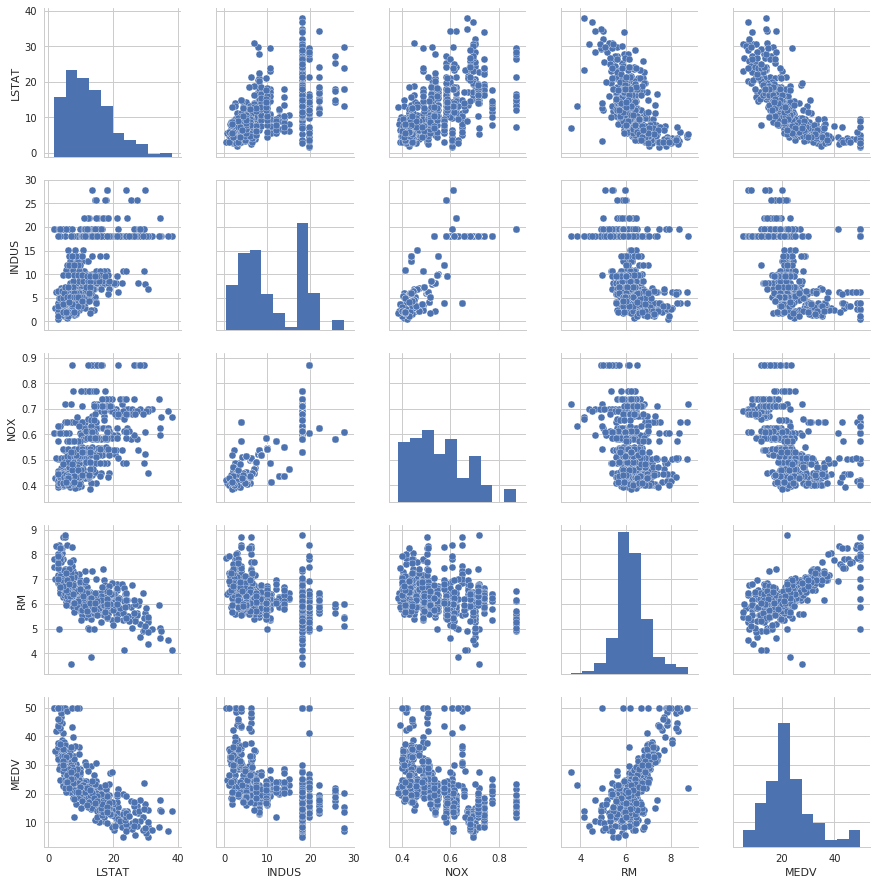

In [4]:
# 查看数据之间的线性关系,利用三三点图
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook') # sns.reset_orig()重新设置显示的背景
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
sns.pairplot(df[cols], size=2.5)
plt.show()

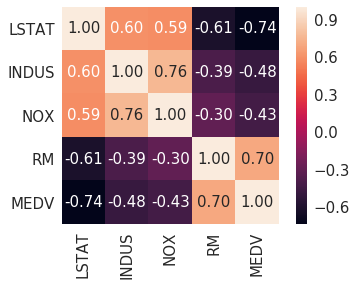

In [5]:
# 计算相关系数
import numpy as np
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f',\
                annot_kws={'size':15}, yticklabels=cols, xticklabels=cols)
plt.show()

In [60]:
class LinearRegressionGD(object):
    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter
        
    def fit(self, X, y):
        self.w_ = np.zeros((1+X.shape[1],1))
        self.cost_ = []
        
        for i in range(self.n_iter):
            output = self.net_input(X)
            # print(output) 506*1
            # print(y)
            # print(output.shape)
            # print(y.shape)
            errors = (y-output)
            # print(errors.shape)
            # print(errors.shape) 506*1
            # print(X.T.dot(errors).shape)
            # print(self.w_[1:].shape)
            # print(self.w_[1:,0].shape)
            self.w_[1:,:] += self.eta * X.T.dot(errors)
            self.w_[0,:] += self.eta * errors.sum()
            # print(errors.shape)
            # print(errors**2)
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:,:]) + self.w_[0,:]
    
    def predict(self, X):
        return self.net_input(X)

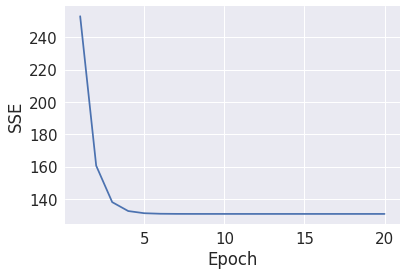

In [61]:
X = df[['RM']].values
y = df[['MEDV']].values
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y)
lr = LinearRegressionGD()
lr.fit(X_std, y_std)
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

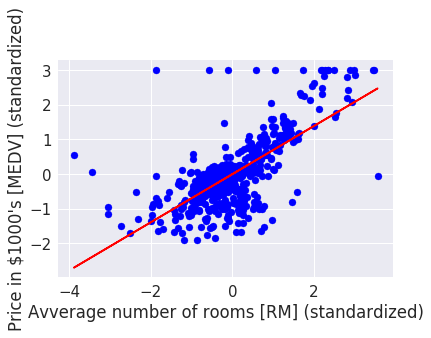

In [68]:
# 可视化线性回归拟合训练数据的良好程度。
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='blue')
    plt.plot(X, model.predict(X), color='red')
    return None

lin_regplot(X_std,y_std,lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel("Price in $1000's [MEDV] (standardized)")
plt.show()

从图像中可以看出来，线性回归反映了随着房间数目的增长，房子价格大致呈现增长的趋势。  
下面讨论怎么样量化一个回归模型的表现。  
从上图中可以看到y=3的曲线，从这条曲线当中，暗示了这个价格可能被限制了，在特定的应用中，知道输出数据的原始值是重要的。  
通过 inverse_transform方法可以获得原始的数据

In [71]:
num_rooms_std = sc_x.transform([[5.0]]) # 注意在这里的输入的shape要满足原始拟合数据的shape，所以必须是二维数组
price_std = lr.predict(num_rooms_std)
print("Price in $1000's: %.3f" % sc_y.inverse_transform(price_std))

Price in $1000's: 10.840


当我们将变量已经标准化之后（center and normalizaton）因为y轴的intercept在这种情况下为0,所以实际商不需要更新截距的权重。
如下所示：

In [72]:
print('Slope:%.3f'%lr.w_[1])
print('Intercept:%.3f'%lr.w_[0])

Slope:0.695
Intercept:-0.000


In [73]:
# 通过scikit-learn来估计参数。
# 这里的线性回归是利用了LIBLINEAR库来更新优化算法，可以更好的对没有标准化的变量进行训练。
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X,y)
print('Slope:%.3f'%slr.coef_[0])
print('Intercept:%.3f'%slr.intercept_)

Slope:9.102
Intercept:-34.671


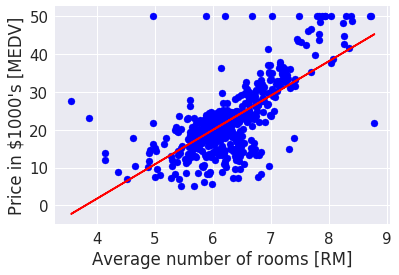

In [74]:
lin_regplot(X,y,slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel("Price in $1000's [MEDV]")
plt.show()

上图所示，拟合情况与上面标准化的情况类似。  

因为线性回归模型可以被异常值影响。在某些情况下，小部分的数据可能会对模型参数的评估造成巨大的影响。  
可以利用统计的方法来检验异常值。  
这里介绍另外一种方法，利用RANdom SAmple Consensus(RANSAC)算法来做稳健回归，也就是用数据的一部分来拟合回归模型，也叫做inliers。

步骤：    
1、 随机选择一部分的样本作为inliers拟合模型。  
2、 将没有拟合模型的数据测试这个拟合好的模型，并且将落在用户给定的忍受度（tolerance）的范围内的点加到inliers中。  
3、 用所有的inliers重新拟合模型。  
4、 估计拟合模型相对于inlier的误差（estimate the error of fitted model versus the inliers）。  
5、 当performace已经达到用户定义的阈值或者它的迭代次数已经达到了，终止算法，重回第一步。

In [77]:
# 用scikit—learn中的RANSACRegression（实现RANSAC算法）
# 默认情况下，residual_threshold的值是目标值y的偏差绝对值的中位数。
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(), max_trials=100, min_samples=50, \
                         residual_metric=lambda x:np.sum(np.abs(x), axis=1),\
                         residual_threshold=5.0, random_state=0)
ransac.fit(X,y)

/home/lily/tf3.6/lib/python3.6/site-packages/sklearn/linear_model/ransac.py:288: DeprecationWarning: 'residual_metric' was deprecated in version 0.18 and will be removed in version 0.20. Use 'loss' instead.
  DeprecationWarning)


RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_skips=inf, max_trials=100, min_samples=50, random_state=0,
        residual_metric=<function <lambda> at 0x7fa01efa8048>,
        residual_threshold=5.0, stop_n_inliers=inf, stop_probability=0.99,
        stop_score=inf)

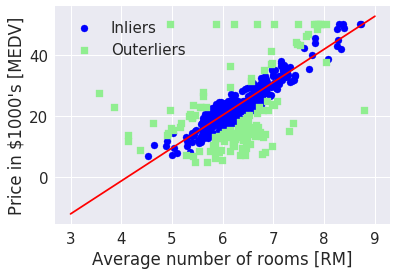

In [82]:
# 查看inliers和outliers
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3,10,1)
line_y_ransac = ransac.predict(line_X[:,np.newaxis])
plt.scatter(X[inlier_mask],y[inlier_mask],c='blue',marker='o',label='Inliers')
plt.scatter(X[outlier_mask],y[outlier_mask],c='lightgreen',marker='s',label='Outerliers')
plt.plot(line_X, line_y_ransac, color='red')
plt.xlabel('Average number of rooms [RM]')
plt.ylabel("Price in $1000's [MEDV]")
plt.legend(loc='upper left')
plt.show()

In [83]:
print('Slope:%.3f'%ransac.estimator_.coef_[0])
print('Intercept:%.3f'%ransac.estimator_.intercept_)

Slope:10.735
Intercept:-44.089


 这里可以看出来，我们减小了数据集中outlier的影响，下面探查哪种模型的泛化能力更好。
 
 下面用所有数据集中的所有变量拟合模型，训练一个多元回归问题。

/home/lily/tf3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


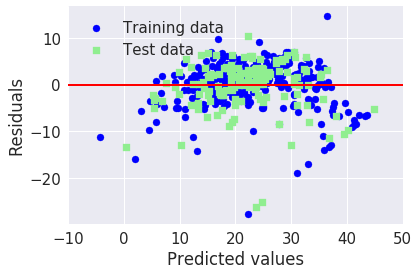

In [84]:
from sklearn.cross_validation import train_test_split
X = df.iloc[:,:-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

plt.scatter(y_train_pred, y_train_pred-y_train, c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred, y_test_pred-y_test, c='lightgreen',marker='s',label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10,50])
plt.show()

好的残差图形表示，这些残差应该随机均匀分布，从上图中可以看出，这个回归线的拟合不能够解释某些信息。 并且从上面的残差图我们可以看出来outlier的值。  
下面利用残差平方和来查看最终值：

In [86]:
from sklearn.metrics import mean_squared_error
print('MSE train: %.3f, test: %.3f'%(mean_squared_error(y_train,y_train_pred),\
                                    mean_squared_error(y_test,y_test_pred)))

MSE train: 19.958, test: 27.196


从上面可以看出来，模型可能有过拟合。下面查看R^2  
$R^{2} = 1-\frac{SSE}{SST} = 1 - \frac{MSE}{Var(y)}$

In [87]:
from sklearn.metrics import r2_score
print('R^2 train:%.3f, test:%.3f'%(r2_score(y_train, y_train_pred), r2_score(y_test,y_test_pred)))

R^2 train:0.765, test:0.673


In [88]:
# 在regression中使用正则表达式
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.1) # ridge regression

from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0) # lasso regression

from sklearn.linear_model import ElasticNet
elastic = ElasticNet(alpha=1.0, l1_ratio=0.5) #Elastic Net

In [89]:
# 多项是拟合
from sklearn.preprocessing import PolynomialFeatures
X = np.array([258.0, 270.0, 294.0,320.0, 342.0, 368.0,396.0, 446.0, 480.0,586.0])[:, np.newaxis]
y = np.array([236.4, 234.4, 252.8,298.6, 314.2, 342.2,360.8, 368.0, 391.2,390.8])
lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

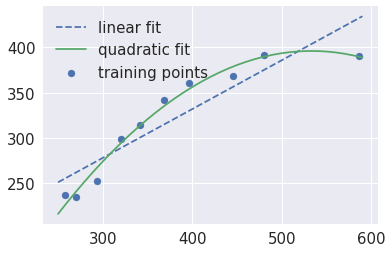

In [95]:
lr.fit(X,y)
X_fit = np.arange(250,600,10)[:,np.newaxis]
y_lin_fit = lr.predict(X_fit)

pr.fit(X_quad,y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

plt.scatter(X,y, label='training points')
plt.plot(X_fit,y_lin_fit,label='linear fit',linestyle='--')
plt.plot(X_fit, y_quad_fit, label='quadratic fit')
plt.legend(loc='upper left')
plt.show()

In [97]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)
print('Training MSE linear:%.3f, quadratic:%.3f'%(mean_squared_error(y,y_lin_pred),\
                                                 mean_squared_error(y,y_quad_pred)))
print('R^2 train:%.3f, test:%.3f'%(r2_score(y, y_lin_pred), r2_score(y,y_quad_pred)))

Training MSE linear:569.780, quadratic:61.330
R^2 train:0.832, test:0.982


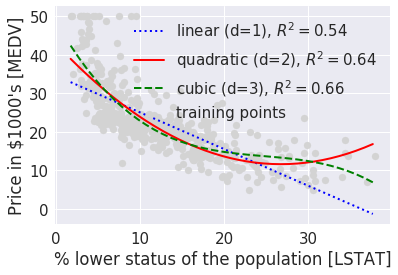

In [98]:
X = df[['LSTAT']].values
y = df['MEDV'].values
regr = LinearRegression()

# create polynomial features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# linear fit
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]
regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

# quadratic fit
regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

# cubic fit
regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

# plot results
plt.scatter(X, y,label='training points',color='lightgray')
plt.plot(X_fit, y_lin_fit,label='linear (d=1), $R^2=%.2f$'% linear_r2,color='blue',lw=2,linestyle=':')
plt.plot(X_fit, y_quad_fit,label='quadratic (d=2), $R^2=%.2f$'% quadratic_r2,color='red',lw=2,linestyle='-')
plt.plot(X_fit, y_cubic_fit,label='cubic (d=3), $R^2=%.2f$'% cubic_r2,color='green',lw=2,linestyle='--')
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper right')
plt.show()

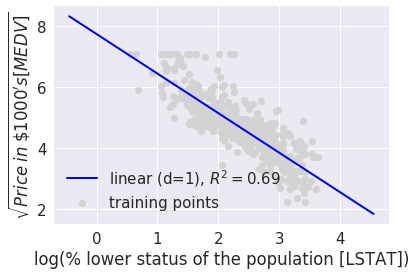

In [99]:
# 从scatter plot中可以看出来 MEDV-LSTAT的三点图之间好像有log的关系，所以对LSTAT做log分析:

# transofrm features
X_log = np.log(X)
y_sqrt = np.sqrt(y)

# fit features
X_fit = np.arange(X_log.min()-1,X_log.max()+1, 1)[:, np.newaxis]
regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

# plot results
plt.scatter(X_log, y_sqrt,label='training points', color='lightgray')
plt.plot(X_fit, y_lin_fit, label='linear (d=1), $R^2=%.2f$' % linear_r2, color='blue', lw=2)
plt.xlabel('log(% lower status of the population [LSTAT])')
plt.ylabel('$\sqrt{Price \; in \; \$1000\'s [MEDV]}$')
plt.legend(loc='lower left')
plt.show()

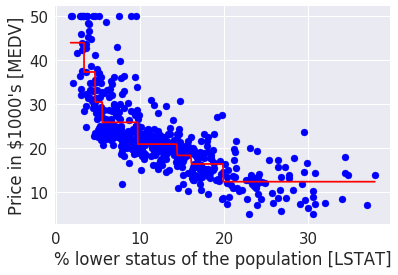

In [101]:
# 用随机森林处理非线性关系

# 利用DecisionTreeRegressor处理MEDV和LSTAT变量之间的非线性关系。

from sklearn.tree import DecisionTreeRegressor
X = df[['LSTAT']].values
y = df[['MEDV']].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X,y)
sort_idx = X.flatten().argsort()
lin_regplot(X[sort_idx],y[sort_idx],tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.show()

MSE train: 1.642, test: 11.052
R^2 train: 0.979, test: 0.878


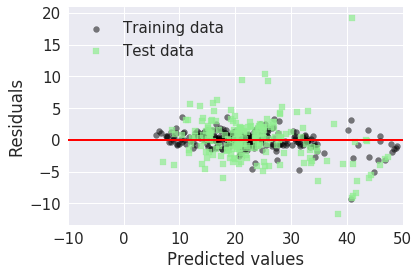

In [110]:
X = df.iloc[:,:-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test =train_test_split(X, y,test_size=0.4,random_state=1)
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=1000,criterion='mse', random_state=1, n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print('MSE train: %.3f, test: %.3f' % ( mean_squared_error(y_train, y_train_pred), \
                                       mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred),\
                                       r2_score(y_test, y_test_pred)))
plt.scatter(y_train_pred, y_train_pred - y_train,c='black', marker='o', s=35, alpha=0.5, label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test, c='lightgreen', marker='s', s=35, alpha=0.7, label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.show()

从上图中可以看出来，残差图比线性模型要好，但是并没有都接近0， 说明模型还存在没有解释的部分。